In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization

In [2]:
# SPDR ETFs
assets = [
    'XLC',  # Communication Services
    'XLY',  # Consumer Discretionary
    'XLP',  # Consumer Staples
    'XLE',  # Energy
    'XLF',  # Financials
    'XLV',  # Health Care
    'XLI',  # Industrials
    'XLB',  # Materials
    'XLRE', # Real Estate
    'XLK',  # Technology
    'XLU',  # Utilities
    'SPY',  # S&P 500
]

# Download data from Yahoo Finance since 2018-06-19 (when all ETFs are available)
start = '2018-06-19'
data = {}
for ticker in assets:
    data[ticker] = yf.download(ticker, start=start)

# Calculate daily returns
returns = pd.DataFrame()
for ticker in assets:
    returns[ticker] = data[ticker]['Adj Close'].pct_change().iloc[1:]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
from functions import optimal_portfolio

def rebalancing_strategy(asset_returns, target_returns, rebalance_threshold, data_lookback):
    '''
    asset_returns: DataFrame of historical asset returns
    target_returns: target annualized returns
    rebalance_threshold: threshold for rebalancing
    data_lookback: number of days to look back for calculating mean and covariance

    Returns a list of weights at each time step
    '''
    num_assets = len(asset_returns.columns)
    num_periods = len(asset_returns)
    optimal_weights = []
    w_prev = [1/num_assets] * num_assets
    for i in range(data_lookback, num_periods):
        # Calculate mean and covariance over the lookback period
        lookback_returns = asset_returns.iloc[i-data_lookback:i-1]
        m = lookback_returns.mean()
        sigma = lookback_returns.cov()
        # Calculate optimal weights
        w = optimal_portfolio(m, sigma, target_returns/252)[0]
        # If any of the weights deviate from their previous weight by more than the threshold, rebalance
        if any([abs(w[i] - w_prev[i]) > rebalance_threshold for i in range(num_assets)]):
            optimal_weights.append(w)
            w_prev = w
        else:
            optimal_weights.append(w_prev)
    return optimal_weights

In [4]:
def strategy_performance(asset_returns, weights, dates):
    '''
    asset_returns: DataFrame of historical asset returns over the same time period as the weights
    weights: list of weights at each time step
    dates: list of dates corresponding to the weights

    Returns a dataframe of portfolio returns, the mean returns, standard deviation, and Sharpe ratio
    '''
    num_periods = len(asset_returns)
    portfolio_returns = []
    for i in range(num_periods):
        portfolio_returns.append(np.dot(weights[i], asset_returns.iloc[i]))
    portfolio_returns = pd.DataFrame(portfolio_returns, index=dates, columns=['Return'])
    mean = portfolio_returns.mean() * 252
    std = portfolio_returns.std() * np.sqrt(252)
    sharpe = mean/std
    return portfolio_returns, mean.iloc[0], std.iloc[0], sharpe.iloc[0]

In [5]:
# Perform Bayesian optimization
def objective_function(target_returns, rebalance_threshold, data_lookback):
    data_lookback = int(data_lookback)
    optimal_weights = rebalancing_strategy(returns, target_returns, rebalance_threshold, data_lookback)
    dates = returns.iloc[data_lookback:].index
    sharpe = strategy_performance(returns.iloc[data_lookback:], optimal_weights, dates)[3]
    return sharpe

pbounds = {
    'target_returns': (0, 0.25),
    'rebalance_threshold': (0, 0.2),
    'data_lookback': (125, 175) # This is very reliably around 150, even given wider bounds
}

optimizer = BayesianOptimization(objective_function, pbounds, random_state=1)
optimizer.maximize(init_points=20, n_iter=100)
print(optimizer.max)

|   iter    |  target   | data_l... | rebala... | target... |
-------------------------------------------------------------
| 1         | 0.5297    | 145.9     | 0.1441    | 2.859e-05 |
| 2         | 0.5898    | 140.1     | 0.02935   | 0.02308   |
| 3         | 0.6204    | 134.3     | 0.06911   | 0.09919   |
| 4         | 0.607     | 151.9     | 0.08384   | 0.1713    |
| 5         | 0.5816    | 135.2     | 0.1756    | 0.006847  |
| 6         | 0.5128    | 158.5     | 0.08346   | 0.1397    |
| 7         | 0.6885    | 132.0     | 0.03962   | 0.2002    |
| 8         | 0.5227    | 173.4     | 0.06268   | 0.1731    |
| 9         | 0.4041    | 168.8     | 0.1789    | 0.02126   |
| 10        | 0.665     | 127.0     | 0.03397   | 0.2195    |
| 11        | 0.6437    | 129.9     | 0.08422   | 0.2395    |
| 12        | 0.5451    | 151.7     | 0.1384    | 0.07888   |
| 13        | 0.4213    | 159.3     | 0.1669    | 0.004572  |
| 14        | 0.575     | 162.5     | 0.1978    | 0.187     |
| 15    

Mean returns:  0.12460480011916726
Standard deviation:  0.17047822059734205
Sharpe ratio:  0.7309133077677724


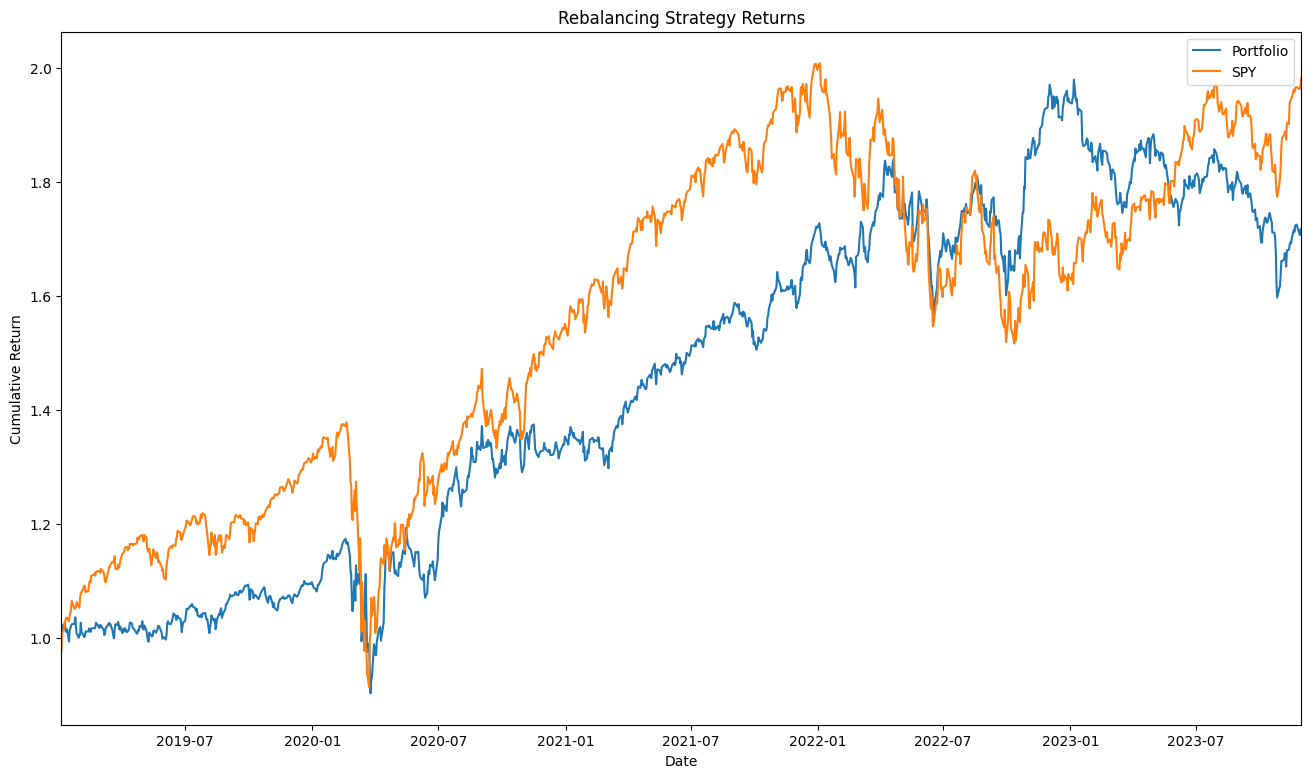

In [6]:
 # Run the strategy
target_returns = optimizer.max['params']['target_returns']
rebalance_threshold = optimizer.max['params']['rebalance_threshold']
data_lookback = int(optimizer.max['params']['data_lookback'])
optimal_weights = rebalancing_strategy(returns, target_returns, rebalance_threshold, data_lookback)
dates = returns.iloc[data_lookback:].index
portfolio_returns, mean, std, sharpe = strategy_performance(returns[data_lookback:], optimal_weights, dates)
print('Mean returns: ', mean)
print('Standard deviation: ', std)
print('Sharpe ratio: ', sharpe)

fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(portfolio_returns.index, (portfolio_returns['Return']+1).cumprod(), label='Portfolio')
ax.plot(portfolio_returns.index, (returns['SPY'].iloc[data_lookback:]+1).cumprod(), label='SPY')
ax.legend()
ax.set_title('Rebalancing Strategy Returns')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Return')
ax.margins(x=0)
plt.show()